In [1]:
import sys
sys.path
sys.path.append('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
import os
from scipy.spatial.transform import Rotation as R
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import axes3d
import sklearn
import matplotlib.cm as cm
from sklearn.cluster import KMeans,OPTICS,DBSCAN
import package.torch_classifier
from sklearn.linear_model import LogisticRegression

In [30]:
import importlib
importlib.reload(package.torch_classifier)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.solver)

<module 'cebra_v2.solver' from '/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code/cebra_v2/solver.py'>

## Utilitaires

In [3]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

## Data Loading

In [4]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/dfc.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/meta.csv")
iu = np.triu_indices(82,k=1)
dfc_flat = dfc[:,:,iu[0],iu[1]]
id_sessions_awake = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake"]
id_sessions_light_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2"]
id_sessions_deep_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4"]
id_sessions_almira = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "almira" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_jade = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "jade" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_khali = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "khali" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_kimiko = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "kimiko" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_rana = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "rana" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]

In [5]:
dict_condition = {"sevoflurane2":0,"sevoflurane4":1}

In [6]:
id_sessions_train = [i for i in range(len(meta)) if meta["monkey"].iloc[i] in ["kimiko"] and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
labels_train = np.array([[dict_condition[meta["condition"].iloc[i]]]*461 for i in range(len(meta)) if meta["monkey"].iloc[i] in ["kimiko"] and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]])
dfc_train = dfc_flat[id_sessions_train,:,:]

In [7]:
id_sessions_val = [i for i in range(len(meta)) if meta["monkey"].iloc[i] in ["jade"] and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
labels_val = np.array([[dict_condition[meta["condition"].iloc[i]]]*461 for i in range(len(meta)) if meta["monkey"].iloc[i] in ["jade"] and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]])
dfc_val = dfc_flat[id_sessions_val,:,:]

In [8]:
id_sessions_test = [i for i in range(len(meta)) if meta["monkey"].iloc[i] in ["rana"] and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
labels_test = np.array([[dict_condition[meta["condition"].iloc[i]]]*461 for i in range(len(meta)) if meta["monkey"].iloc[i] in ["rana"] and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]])
dfc_test = dfc_flat[id_sessions_test,:,:]

## Cebra

In [9]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        3,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True,
    initialization = "default"
        )

In [10]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(dfc_train,labels_train) #, discrete = labels_train)
test_dataset = cebra2.dataset.SimpleMultiSessionDataset(dfc_test,labels_test)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 1000, time_delta = 5) # discrete = labels_train)

In [129]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.solver)
importlib.reload(cebra2.criterion)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code/cebra_v2/dataset.py'>

In [14]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'euclidean', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 0.01, beta = 10,learning_rate = 3e-1, model = model)

In [15]:
cebra_fc.fit(fc_loader,test_dataset)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

KeyboardInterrupt: 

/tmp/ipykernel_1182095/754541293.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,0], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)


"\nblack_patch = mpatches.Patch(color='black', label='light-propofol')\nred_patch = mpatches.Patch(color='red', label='deep-propofol')\ngreen_patch = mpatches.Patch(color='green', label='awake')\nax1.legend(handles=[black_patch,red_patch,green_patch])\n"

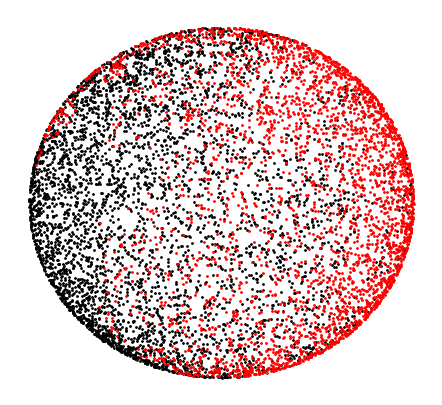

In [99]:
fig = plt.figure(figsize = (12,5))

fc_emb = _compute_emissions_single(cebra_fc, fc_dataset.neural.reshape(-1,3321)).reshape(-1,461,3)
ax1 = plt.subplot(121)
colors = ["black",'red','green']
for i in range(18):
    ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,0], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_train[i,0]], s=1)
#ax1.xticks() 
ax1.axis('off')

"""
black_patch = mpatches.Patch(color='black', label='light-propofol')
red_patch = mpatches.Patch(color='red', label='deep-propofol')
green_patch = mpatches.Patch(color='green', label='awake')
ax1.legend(handles=[black_patch,red_patch,green_patch])
"""

/tmp/ipykernel_1182095/2879219185.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,0], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_val[i,0]], s=1)


(-1.0983771681785583,
 1.0994452834129333,
 -1.0989804923534394,
 1.098755544424057)

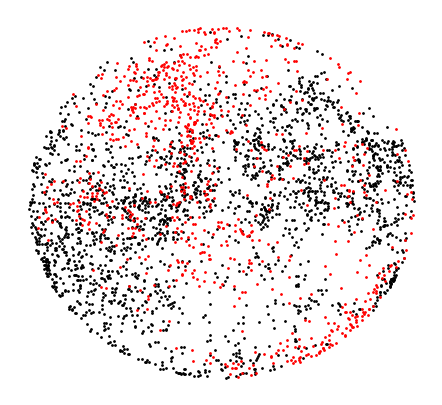

In [101]:
fc_emb = _compute_emissions_single(cebra_fc, torch.from_numpy(dfc_val.reshape(-1,3321)).type(torch.float32)).reshape(-1,461,3)
fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
colors = ["black",'red','green']
for i in range(7):
    ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,0], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_val[i,0]], s=1)
#ax1.xticks() 
ax1.axis('off')

/tmp/ipykernel_1182095/4011572343.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,0], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)


(-1.0996213763952256,
 1.099362036585808,
 -1.0984823644161223,
 1.0992743909358977)

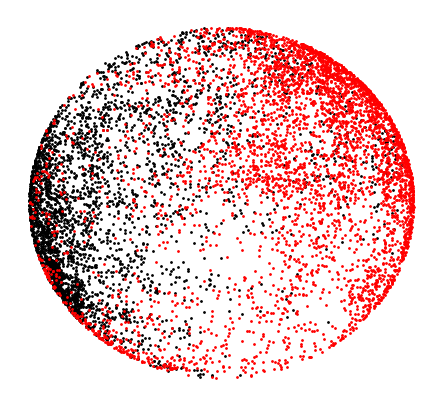

In [104]:
fc_emb = _compute_emissions_single(cebra_fc, torch.from_numpy(dfc_test.reshape(-1,3321)).type(torch.float32)).reshape(-1,461,3)
fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
colors = ["black",'red','green']
for i in range(18):
    ax1.scatter(fc_emb[i,:,2], fc_emb[i,:,0], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)
#ax1.xticks() 
ax1.axis('off')

In [204]:
dfc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
dfc_test_vector = dfc_test_vector.type(torch.float32)

In [205]:
#dfc_test_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(dfc_test)))
a,b,c = dfc_test_vector.shape
data = dfc_test_vector.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)

/tmp/ipykernel_18949/48964752.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)


'\nblack_patch = mpatches.Patch(color=\'black\', label=\'light-propofol\')\nred_patch = mpatches.Patch(color=\'red\', label=\'deep-propofol\')\ngreen_patch = mpatches.Patch(color=\'green\', label=\'awake\')\nax1.legend(loc = "upper left",handles=[black_patch,red_patch,green_patch])\n'

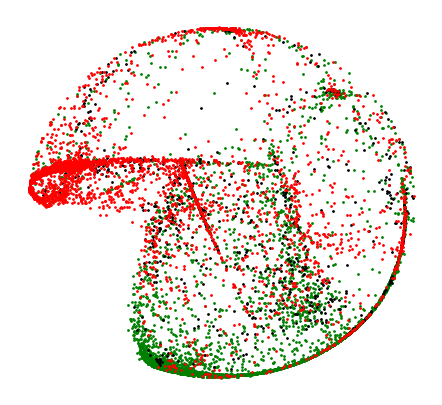

In [206]:
a,b,c = dfc_test_vector.shape
data = dfc_test_vector.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red','green']
for i in range(28):
    if labels_test[i,0] in [0,1,2]:
        ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels_test[i,0]], s=1)
#ax1.xticks() 
ax1.axis('off')
"""
black_patch = mpatches.Patch(color='black', label='light-propofol')
red_patch = mpatches.Patch(color='red', label='deep-propofol')
green_patch = mpatches.Patch(color='green', label='awake')
ax1.legend(loc = "upper left",handles=[black_patch,red_patch,green_patch])
"""

In [46]:
torch.save(cebra_fc.model.state_dict(), '/volatile/aurelien_stumpf_mascles/project/models/model.pth')

## Clustering

For n_clusters = 2 The average silhouette_score is : 0.4669204


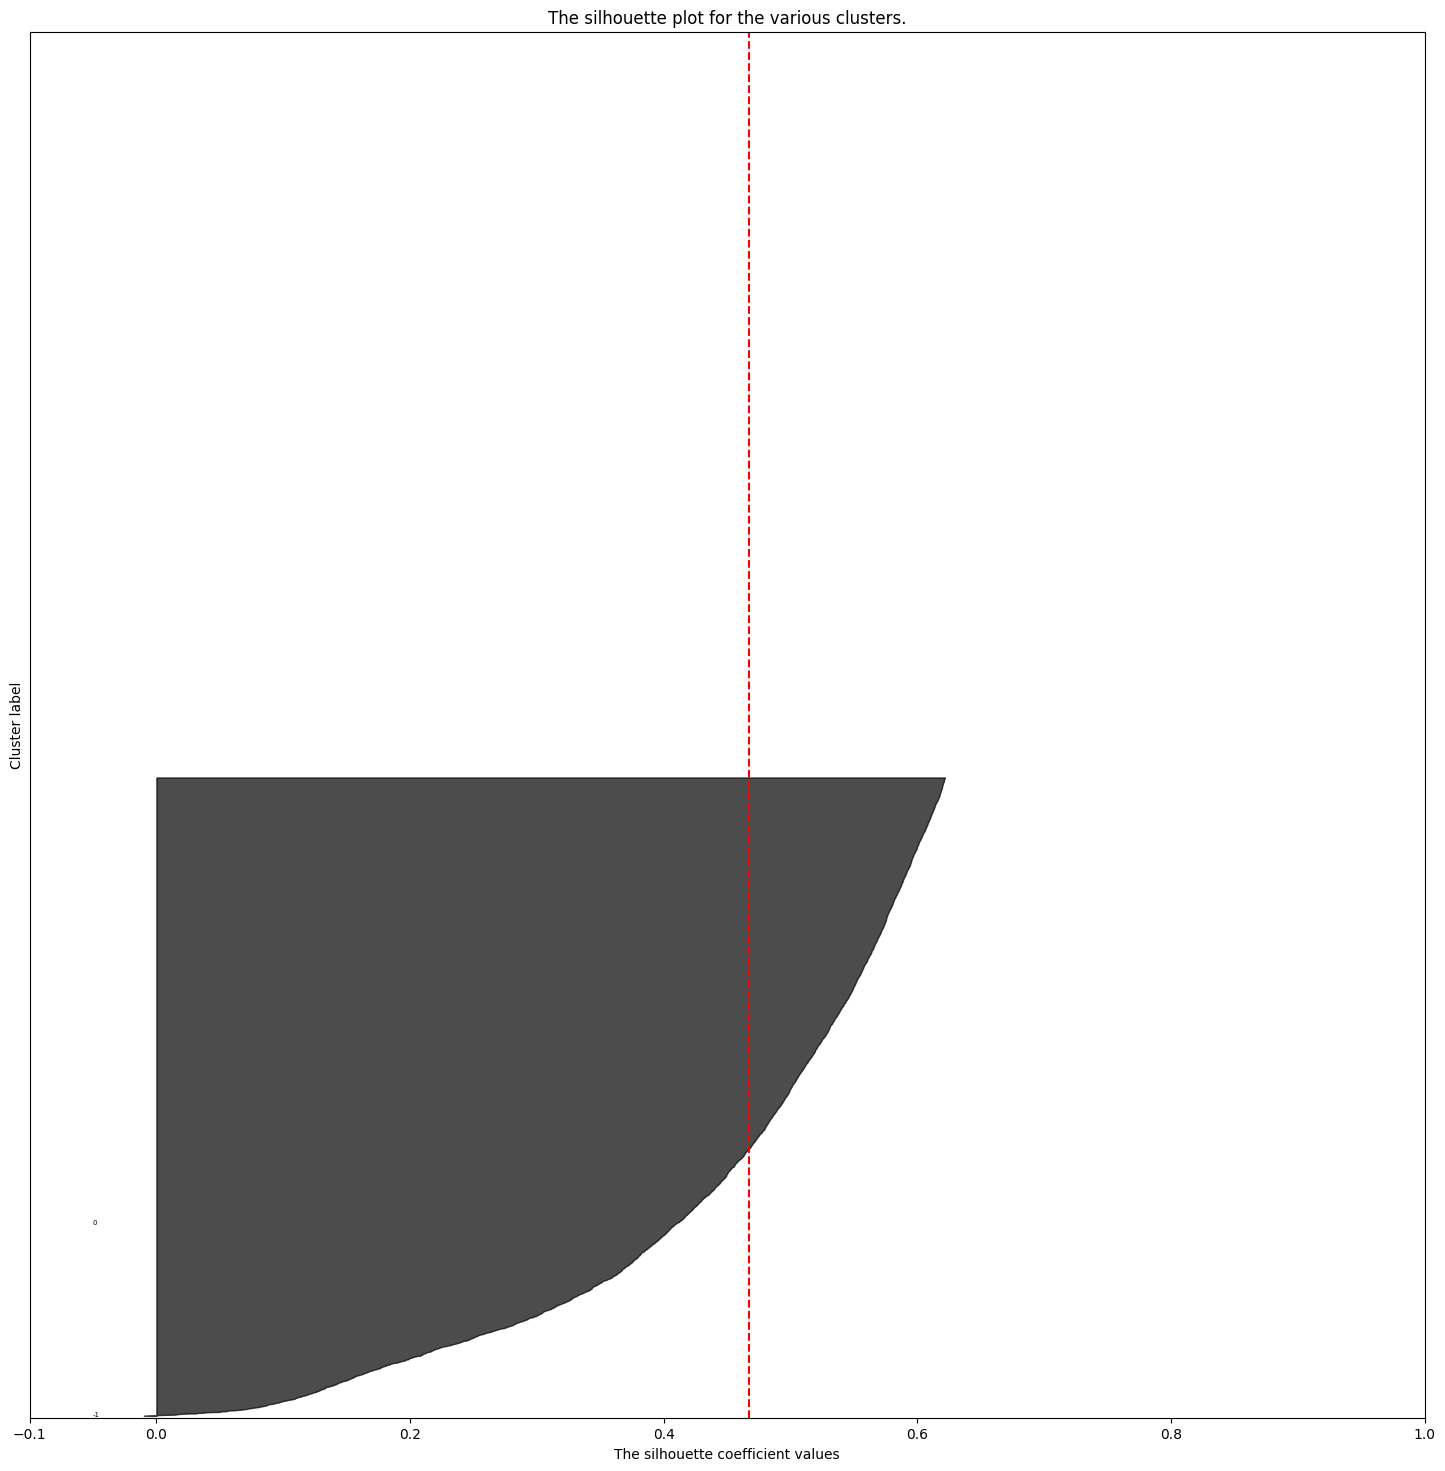

In [119]:
# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 18)

X = fc_emb.reshape(-1,3)

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
#clustering = DBSCAN(eps=0.1, min_samples=4).fit(X)
#clustering = OPTICS(min_samples=2, min_cluster_size = 2).fit(X)
clustering = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
cluster_labels = clustering.labels_
n_clusters = len(np.unique(cluster_labels))

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, 1.3*len(X)])

y_lower = 10
for i in range(-1,n_clusters-1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.3 * size_cluster_i, str(i), fontsize=5)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [122]:
labels.shape

(25, 461)

/tmp/ipykernel_1989496/6947688.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels[i,:]], s=1)


"\nblack_patch = mpatches.Patch(color='black', label='light-propofol')\nred_patch = mpatches.Patch(color='red', label='deep-propofol')\ngreen_patch = mpatches.Patch(color='green', label='awake')\nax1.legend(handles=[black_patch,red_patch,green_patch])\n"

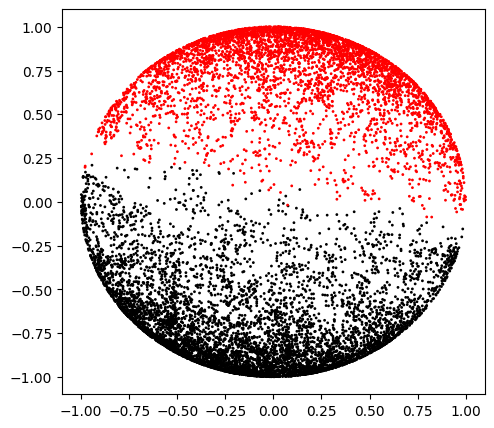

In [124]:
fc_emb = fc_emb.reshape((-1,461,3))
fig = plt.figure(figsize = (12,5))
labels = cluster_labels.reshape(-1,461)

ax1 = plt.subplot(121)
colors = np.array(["black",'red'])
for i in range(25):
    ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels[i,:]], s=1)
#ax1.xticks() 
ax1.axis('on')

"""
black_patch = mpatches.Patch(color='black', label='light-propofol')
red_patch = mpatches.Patch(color='red', label='deep-propofol')
green_patch = mpatches.Patch(color='green', label='awake')
ax1.legend(handles=[black_patch,red_patch,green_patch])
"""

In [128]:
def display(states,li_titles):
    fig = plt.figure(figsize=(11, 11))
    
    # setting values to rows and column variables
    n = len(states)
    rows = int(np.sqrt(n))+1
    columns = n // (rows-1)
    
    for i in range(n):
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(states[i],cmap="hot")
        plt.axis('off')
        plt.title(li_titles[i])

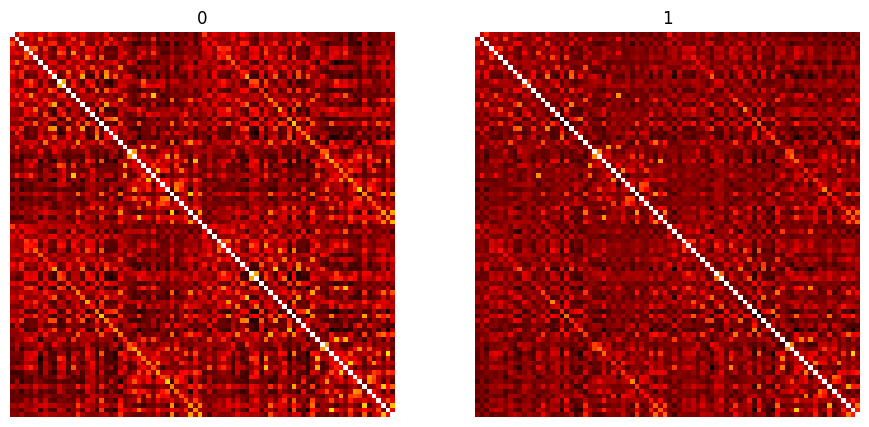

In [129]:
list_label = clustering.labels_
dfc_train = dfc[id_sessions_train,:,:,:]
data = dfc_train.reshape(-1,82,82)
mean_states = np.array([np.mean(data[clustering.labels_ == i],axis=0) for i in np.unique(clustering.labels_)])
display(mean_states,np.unique(clustering.labels_))

### Algorithme de classification

In [86]:
net = package.torch_classifier.MLP(input_dim = 3,output_dim = 2)

X = _compute_emissions_single(cebra_fc, fc_dataset.neural.reshape(-1,3321)).reshape(-1,3)
y = labels_train.reshape((-1))

X_test =  _compute_emissions_single(cebra_fc, torch.from_numpy(dfc_test.reshape(-1,3321)).type(torch.float32)).reshape(-1,3)
y_test = labels_train.reshape((-1))

#X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
train = package.torch_classifier.SimpleDataset(X,y)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 2, n_samples = 1000)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=True, num_workers=6)

In [87]:
package.torch_classifier.Train(net,train_loader,test_loader,100,lr = 0.1)

Train loss 0.6700, Train accuracy 65.93%
Test accuracy 46.52%
Train loss 0.0742, Train accuracy 99.43%
Test accuracy 71.79%
Train loss 0.0038, Train accuracy 99.88%
Test accuracy 69.38%
Train loss 0.0016, Train accuracy 99.98%
Test accuracy 70.20%
Train loss 0.0012, Train accuracy 99.97%
Test accuracy 69.98%
Train loss 0.0010, Train accuracy 99.98%
Test accuracy 70.09%
Train loss 0.0009, Train accuracy 99.99%


Exception ignored in: <function _releaseLock at 0x7f1a21088ca0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Test accuracy 70.02%
Train loss 0.0008, Train accuracy 99.99%
Test accuracy 70.02%
Train loss 0.0009, Train accuracy 99.98%
Test accuracy 70.01%
Train loss 0.0010, Train accuracy 99.98%
Test accuracy 70.02%
Train loss 0.0006, Train accuracy 100.00%
Test accuracy 69.98%
Train loss 0.0008, Train accuracy 99.99%
Test accuracy 70.02%
Train loss 0.0007, Train accuracy 99.99%
Test accuracy 70.02%
Train loss 0.0008, Train accuracy 99.98%
Test accuracy 70.06%
Train loss 0.0007, Train accuracy 99.99%
Test accuracy 70.07%
Train loss 0.0008, Train accuracy 99.98%


Exception ignored in: <function _releaseLock at 0x7f1a21088ca0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Test accuracy 70.06%
Train loss 0.0007, Train accuracy 99.99%
Test accuracy 70.06%
Train loss 0.0007, Train accuracy 99.99%
Test accuracy 70.06%
Train loss 0.0007, Train accuracy 99.98%
Test accuracy 70.09%
Train loss 0.0007, Train accuracy 99.98%
Test accuracy 70.04%
Train loss 0.0007, Train accuracy 99.99%
Test accuracy 70.10%
Train loss 0.0007, Train accuracy 99.98%
Test accuracy 70.11%
Train loss 0.0006, Train accuracy 99.99%
Test accuracy 70.07%
Train loss 0.0007, Train accuracy 99.98%
Test accuracy 70.09%


KeyboardInterrupt: 

In [69]:
z.shape

(100, 100)

(-1.0999914757517075,
 1.0999914757517075,
 -1.0999674529962649,
 1.0999984501426794)

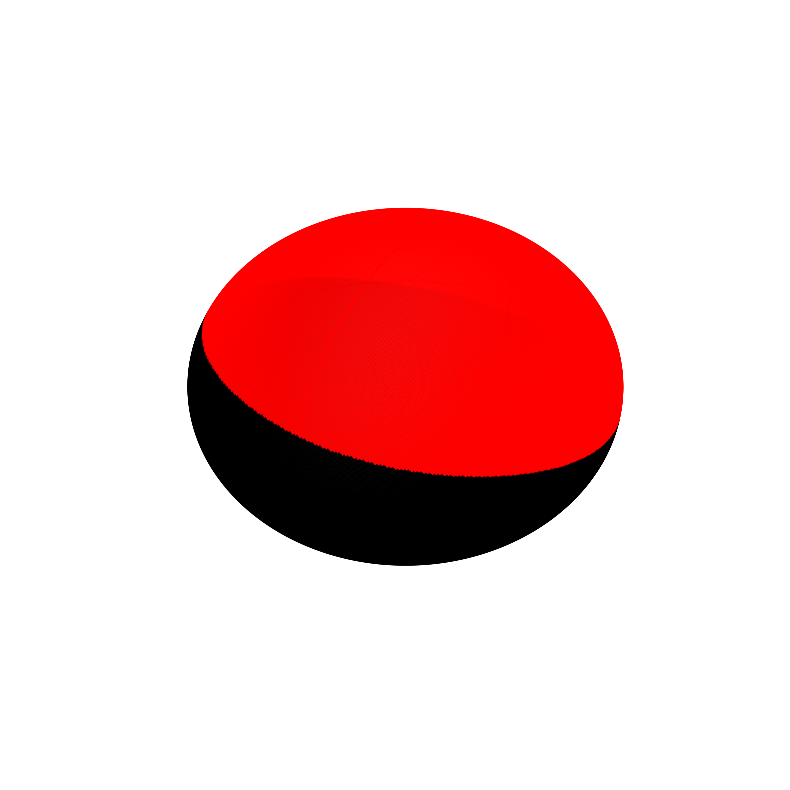

In [88]:
a,b = np.meshgrid(np.linspace(0,2*np.pi,400),np.linspace(0,2*np.pi,400))
x = (np.cos(a)*np.cos(b)).reshape(-1,1)
y = (np.sin(a)*np.cos(b)).reshape(-1,1)
z = np.sin(b).reshape(-1,1)
sphere = np.concatenate((x,y,z),axis = 1)

net.eval()
probas = torch.exp(net(torch.from_numpy(sphere).type(torch.float32)))
res = torch.argmax(probas,dim=1)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
colors = ["black",'red']
ax.scatter(sphere[:,2], sphere[:,0], sphere[:,1], cmap = matplotlib.colors.ListedColormap(colors), c = res, s=1)
#ax1.xticks() 
ax.axis('off') 

In [74]:
torch.save(net.state_dict(), '/volatile/aurelien_stumpf_mascles/project/models/classifier.pth')

In [89]:
net.eval()
for session in range(18):
    emb = torch.from_numpy(_compute_emissions_single(cebra_fc, torch.from_numpy(dfc_test[session,:]).type(torch.float32)))
    probas = torch.sum(torch.exp(net(emb.type(torch.float32))),dim=0)/464
    res = torch.argmax(probas,dim=0)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels_test[session,0],res,probas.detach().numpy()))

True label : 0, Predicted label : 0, Probas : [9.9353361e-01 8.5951984e-07]
True label : 0, Predicted label : 0, Probas : [9.9353451e-01 1.3101244e-08]
True label : 0, Predicted label : 0, Probas : [9.9353451e-01 3.7919655e-08]
True label : 0, Predicted label : 0, Probas : [9.9353451e-01 4.1592923e-08]
True label : 0, Predicted label : 0, Probas : [0.98701805 0.00651649]
True label : 0, Predicted label : 0, Probas : [0.90236336 0.09117111]
True label : 0, Predicted label : 0, Probas : [0.9723613  0.02117317]
True label : 0, Predicted label : 0, Probas : [0.92343414 0.07010033]
True label : 1, Predicted label : 0, Probas : [0.92155844 0.07197606]
True label : 1, Predicted label : 0, Probas : [0.84289885 0.15063563]
True label : 1, Predicted label : 0, Probas : [0.89224505 0.10128946]
True label : 1, Predicted label : 1, Probas : [0.41378987 0.5797447 ]
True label : 1, Predicted label : 1, Probas : [0.27615392 0.7173805 ]
True label : 1, Predicted label : 1, Probas : [0.46296984 0.530564

In [99]:
net.eval()
accu = torch.zeros(2)
for session in range(18):
    emb = torch.from_numpy(_compute_emissions_single(cebra_fc, torch.from_numpy(dfc_test[session,:]).type(torch.float32)))
    probas = torch.exp(net(emb.type(torch.float32)))
    res = torch.argmax(probas,dim=1)
    accu[res] += 1
print(accu/18)

tensor([0.9444, 0.7778])
